<div class="alert alert-info">
  <strong>Imports</strong>
</div>

In [19]:
import pandas as pd
import numpy as np, scipy.stats as stats
import os
from pathlib import Path
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from haversine import haversine_vector, Unit
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from functools import reduce
from sklearn.neural_network import MLPRegressor
from IPython.display import display
import joblib

<div class="alert alert-info">
  <strong>Helper Functions/ Data Import</strong>
</div>

In [ ]:
base = Path("data")
soil = pd.read_csv(base / "SoilMoi0_10cm_inst_data.csv")
tveg = pd.read_csv(base / "TVeg_tavg_data.csv")
yield_df = pd.read_csv(base / "Yield_and_Production_data.csv")

def summarise_monthly(df, var_prefix, agg_funcs=None):
    if agg_funcs is None:
        agg_funcs = ['mean', 'std', 'min', 'max', 'median', 'skew']
    month_cols = [c for c in df.columns if c.startswith(var_prefix) and "_month_" in c]
    long = df.melt(id_vars=['longitude', 'latitude', 'year'], value_vars=month_cols, var_name='month', value_name=var_prefix)
    grouped = long.groupby(['longitude', 'latitude', 'year'])[var_prefix].agg(agg_funcs).reset_index()
    new_cols = ['longitude', 'latitude', 'year'] + [f"{var_prefix}_{f}" for f in agg_funcs]
    grouped.columns = new_cols
    return grouped



def year_range(path: Path, year_col_options=("year","Year")):
    """
    Fast‑but‑complete: streams the entire file in chunks and tracks min/max years.
    Works even on multi‑GB CSVs.
    """
    year_col = None
    # detect the year column name from the header only once
    with open(path, "r") as f:
        header = f.readline().strip().split(",")
    for col in year_col_options:
        if col in header:
            year_col = col; break
    if year_col is None:
        raise ValueError(f"No 'year' column found in {path.name}")

    min_year, max_year = None, None
    for chunk in pd.read_csv(path, usecols=[year_col], chunksize=250_000):
        y = chunk[year_col]
        cm, cM = y.min(), y.max()
        min_year = cm if min_year is None else min(min_year, cm)
        max_year = cM if max_year is None else max(max_year, cM)
    print(f"{path.name:<35s}  {min_year:.0f} – {max_year:.0f}")

def map_points_to_country(df, centroids_df):
    df = df.copy()
    original_count = len(df)

    # Prepare input coordinate lists
    grid_points = list(zip(df['latitude'], df['longitude']))
    centroid_points = list(zip(centroids_df['centroid_lat'], centroids_df['centroid_lon']))
    centroid_radii_km = np.array(centroids_df['radius_deg']) * 100 # 1 deg ≈ 100 km
    centroid_countries = centroids_df['country'].values

    # Calculate distance matrix (N grid points x M centroids)
    distance_matrix = haversine_vector(grid_points, centroid_points, Unit.KILOMETERS, comb=True)
    distance_matrix = np.array(distance_matrix).T

    assigned_countries = []

    for i in range(distance_matrix.shape[0]):
        distances = distance_matrix[i]
        mask = distances <= centroid_radii_km
        if np.any(mask):
            closest_idx = np.argmin(np.where(mask, distances, np.inf))
            assigned_countries.append(centroid_countries[closest_idx])
        else:
            assigned_countries.append(None)
            
    df['country'] = assigned_countries
    mapped_count = df['country'].notna().sum()
    print(f"Mapped: {mapped_count} / {original_count} ({mapped_count/original_count:.2%}) rows assigned a country")
    unique_countries = df['country'].nunique()
    print(f'Unique countries assigned: {unique_countries}')
    
    return df.dropna(subset=['country'])

centroids_df = pd.read_csv(base / "country_latitude_longitude_area_lookup.csv")
centroids_df.rename(columns={
    "centroid latitude": "centroid_lat",
    "centroid longitude": "centroid_lon",
    "centroid radius": "radius_deg"
}, inplace=True)



VAR_FILES = {
    "SoilMoi0_10cm_inst": "SoilMoi0_10cm_inst_data.csv",
    "SoilMoi10_40cm_inst": "SoilMoi10_40cm_inst_data.csv",
    "SoilMoi40_100cm_inst": "SoilMoi40_100cm_inst_data.csv",
    "SoilMoi100_200cm_inst": "SoilMoi100_200cm_inst_data.csv",
    "SoilTMP0_10cm_inst": "SoilTMP0_10cm_inst_data.csv",
    "SoilTMP10_40cm_inst": "SoilTMP10_40cm_inst_data.csv",
    "SoilTMP40_100cm_inst": "SoilTMP40_100cm_inst_data.csv",
    "SoilTMP100_200cm_inst": "SoilTMP100_200cm_inst_data.csv",
    "TVeg_tavg"         : "TVeg_tavg_data.csv",
    "TWS_inst" : "TWS_inst_data.csv",
    "Rainf_tavg"        : "Rainf_tavg_data.csv",
    "ESoil_tavg" : "ESoil_tavg_data.csv",
    "Snowf_tavg" : "Snowf_tavg_data.csv",
    "CanopInt": "CanopInt_inst_data.csv"
}
LAND_CSV = base / "Land_cover_percent_data.csv"
CENTROIDS_CSV = base / "country_latitude_longitude_area_lookup.csv"
YIELD_CSV     = base / "Yield_and_Production_data.csv"

<div class="alert alert-info">
  <strong>Preprocessing</strong>
</div>

In [21]:
for prefix, fname in VAR_FILES.items():
    print(f"\n--- {fname} ---")
    df = pd.read_csv(base / fname)
    # Years
    print(f"Years: {df['year'].min()} – {df['year'].max()}")
    # NaN check
    na_count = df.isna().sum().sum()
    print(f"Total missing values: {na_count}")
    if na_count > 0:
        print(df.isna().sum())
    # All-zero columns
    zero_cols = (df.drop(columns=['longitude','latitude','year']).sum() == 0)
    if zero_cols.any():
        print("All-zero columns:", zero_cols[zero_cols].index.tolist())
    # Shape
    print("Shape:", df.shape)

# Yield file
df = pd.read_csv(YIELD_CSV)
print(f"\n--- Yield data ---\nYears: {df['Year'].min()} – {df['Year'].max()}")
print(f"Total missing: {df.isna().sum().sum()}")
print("Shape:", df.shape)

# Land cover file
df = pd.read_csv(LAND_CSV)
print(f"\n--- Land cover data ---\nYears: {df['year'].min()} – {df['year'].max()}")
print(f"Total missing: {df.isna().sum().sum()}")
print("Shape:", df.shape)



--- SoilMoi0_10cm_inst_data.csv ---
Years: 2010 – 2022
Total missing values: 0
Shape: (194298, 15)

--- SoilMoi10_40cm_inst_data.csv ---
Years: 2010 – 2022
Total missing values: 0
Shape: (194298, 15)

--- SoilMoi40_100cm_inst_data.csv ---
Years: 2010 – 2022
Total missing values: 0
Shape: (194298, 15)

--- SoilMoi100_200cm_inst_data.csv ---
Years: 2010 – 2022
Total missing values: 14946
longitude                             0
latitude                              0
SoilMoi100_200cm_inst_month_1         0
SoilMoi100_200cm_inst_month_2         0
SoilMoi100_200cm_inst_month_3         0
SoilMoi100_200cm_inst_month_4         0
SoilMoi100_200cm_inst_month_5         0
SoilMoi100_200cm_inst_month_6         0
SoilMoi100_200cm_inst_month_7         0
SoilMoi100_200cm_inst_month_8     14946
SoilMoi100_200cm_inst_month_9         0
SoilMoi100_200cm_inst_month_10        0
SoilMoi100_200cm_inst_month_11        0
SoilMoi100_200cm_inst_month_12        0
year                                  0
dtype: int

In [22]:
agg_frames = []
for prefix, fname in VAR_FILES.items():
    df_raw = pd.read_csv(base / fname)
    df_raw = df_raw.fillna(df_raw.mean())  # Impute NaNs with column mean

In [23]:
for prefix, fname in VAR_FILES.items():
    df_raw = pd.read_csv(base / fname)
    df_raw = df_raw.fillna(df_raw.mean())
    nan_count = df_raw.isna().sum().sum()
    if nan_count == 0:
        print(f"[OK] All NaNs fixed in {fname}")
    else:
        print(f"[WARNING] NaNs remain in {fname}: {nan_count} cells")
        print(df_raw.isna().sum())


[OK] All NaNs fixed in SoilMoi0_10cm_inst_data.csv
[OK] All NaNs fixed in SoilMoi10_40cm_inst_data.csv
[OK] All NaNs fixed in SoilMoi40_100cm_inst_data.csv
[OK] All NaNs fixed in SoilMoi100_200cm_inst_data.csv
[OK] All NaNs fixed in SoilTMP0_10cm_inst_data.csv
[OK] All NaNs fixed in SoilTMP10_40cm_inst_data.csv
[OK] All NaNs fixed in SoilTMP40_100cm_inst_data.csv
[OK] All NaNs fixed in SoilTMP100_200cm_inst_data.csv
[OK] All NaNs fixed in TVeg_tavg_data.csv
[OK] All NaNs fixed in TWS_inst_data.csv
[OK] All NaNs fixed in Rainf_tavg_data.csv
[OK] All NaNs fixed in ESoil_tavg_data.csv
[OK] All NaNs fixed in Snowf_tavg_data.csv
[OK] All NaNs fixed in CanopInt_inst_data.csv


In [24]:
for prefix, fname in VAR_FILES.items():
    print(f"\n--- {fname} ---")
    df_raw = pd.read_csv(base / fname)
    print(df_raw.describe().T)

print("\n--- Land cover ---")
land = pd.read_csv(LAND_CSV)
display(land.describe().T)

print("\n--- Yield ---")
yield_df = pd.read_csv(YIELD_CSV)
display(yield_df.describe().T)



--- SoilMoi0_10cm_inst_data.csv ---
                                count         mean        std     min  \
longitude                    194298.0    18.470226  84.415994  -176.5   
latitude                     194298.0    32.124247  31.688224   -54.5   
SoilMoi0_10cm_inst_month_1   194298.0    27.893415  17.071655     2.0   
SoilMoi0_10cm_inst_month_2   194298.0    28.166069  17.257248     2.0   
SoilMoi0_10cm_inst_month_3   194298.0    28.318279  17.251503     2.0   
SoilMoi0_10cm_inst_month_4   194298.0    28.143892  17.148169     2.0   
SoilMoi0_10cm_inst_month_5   194298.0    26.476778  16.696510     2.0   
SoilMoi0_10cm_inst_month_6   194298.0    24.552648  16.518279     2.0   
SoilMoi0_10cm_inst_month_7   194298.0    23.805600  16.688898     2.0   
SoilMoi0_10cm_inst_month_8   194298.0    23.907224  16.679787     2.0   
SoilMoi0_10cm_inst_month_9   194298.0    24.465656  16.618106     2.0   
SoilMoi0_10cm_inst_month_10  194298.0    25.338906  16.499939     2.0   
SoilMoi0_10cm_

,count,mean,std,min,25%,50%,75%,max
longitude,644280.0,0.000000,102.190669,-176.5,-88.50,0.0,88.50,176.5
latitude,644280.0,10.000000,40.413519,-59.5,-24.75,10.0,44.75,79.5
year,644280.0,2016.000000,3.741660,2010.0,2013.00,2016.0,2019.00,2022.0
Land_cover_percent_class_1,644280.0,71.455203,44.943357,0.0,0.00,100.0,100.00,100.0
Land_cover_percent_class_2,644280.0,0.491746,5.291446,0.0,0.00,0.0,0.00,100.0
Land_cover_percent_class_3,644280.0,2.020803,13.076171,0.0,0.00,0.0,0.00,100.0
Land_cover_percent_class_4,644280.0,0.079276,1.716958,0.0,0.00,0.0,0.00,98.0
Land_cover_percent_class_5,644280.0,0.617419,5.846940,0.0,0.00,0.0,0.00,100.0
Land_cover_percent_class_6,644280.0,1.091378,8.266428,0.0,0.00,0.0,0.00,100.0
Land_cover_percent_class_7,644280.0,0.122302,2.486848,0.0,0.00,0.0,0.00,100.0



--- Yield ---


,count,mean,std,min,25%,50%,75%,max
Year,158269.0,2016.021400,3.740732e+00,2010.0,2013.0,2016.0,2019.0,2022.0
Value,158269.0,873482.735331,1.275511e+07,0.0,1438.0,6581.6,34142.1,768594154.0


In [25]:
zero_cols = (df_raw.drop(columns=['longitude','latitude','year'], errors='ignore').sum() == 0)
if zero_cols.any():
    print("All-zero columns:", zero_cols[zero_cols].index.tolist())
dupes = df_raw.duplicated().sum()
if dupes > 0:
    print(f"Duplicate rows: {dupes}")

In [26]:
print(yield_df.columns)
print(yield_df.head())


Index(['Domain', 'Country', 'Element', 'Item Code (CPC)', 'Item', 'Year',
       'Value', 'Flag'],
      dtype='object')
                         Domain      Country     Element Item Code (CPC)  \
0  Crops and livestock products  Afghanistan       Yield           01341   
1  Crops and livestock products  Afghanistan  Production           01341   
2  Crops and livestock products  Afghanistan       Yield           01341   
3  Crops and livestock products  Afghanistan  Production           01341   
4  Crops and livestock products  Afghanistan       Yield           01341   

     Item  Year    Value Flag  
0  Apples  2010   7000.0    A  
1  Apples  2010  59850.0    A  
2  Apples  2011   7000.0    A  
3  Apples  2011  62041.0    A  
4  Apples  2012   7651.9    A  


In [27]:
yield_df = yield_df[yield_df['Element'] == 'Yield']
print(yield_df.duplicated(subset=['Country', 'Year', 'Item']).sum())

0


In [28]:
land_df = pd.read_csv(LAND_CSV)

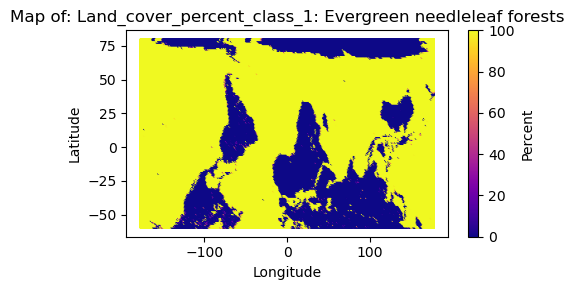

In [29]:
lc_class = "Land_cover_percent_class_1"

plt.figure(figsize=(5,3))
plt.scatter(land_df['longitude'], land_df['latitude'], c=land_df[lc_class], cmap='plasma', s=1)
plt.colorbar(label='Percent')
plt.title(f'Map of: {lc_class}: Evergreen needleleaf forests')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

### Define MODIS land cover class names, and their order
<a href="https://worldview.earthdata.nasa.gov/?v=-602.4042517777077,-296.23423551658345,446.21805375181435,286.51576448341655&l=Reference_Labels_15m(hidden),Reference_Features_15m(hidden),Coastlines_15m(hidden),MODIS_Combined_L3_IGBP_Land_Cover_Type_Annual(disabled=17-0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15),VIIRS_NOAA21_CorrectedReflectance_TrueColor(hidden),VIIRS_NOAA20_CorrectedReflectance_TrueColor(hidden),VIIRS_SNPP_CorrectedReflectance_TrueColor(hidden),MODIS_Aqua_CorrectedReflectance_TrueColor(hidden),MODIS_Terra_CorrectedReflectance_TrueColor(hidden)&lg=true&t=2015-04-15-T16%3A35%3A27Z">Link to Nasa land cover data</a>

In [30]:

MODIS_CLASSES = {
    1: 'Water_bodies',
    2: 'Evergreen_needleleaf_forests',
    3: 'Evergreen_broadleaf_forests',
    4: 'Deciduous_needleleaf_forests',
    5: 'Deciduous_broadleaf_forests',
    6: 'Mixed_forests',
    7: 'Closed_shrublands',
    8: 'Open_shrublands',
    9: 'Woody_savannas',
    10: 'Savannas',
    11: 'Grasslands',
    12: 'Permanent_wetlands',
    13: 'Croplands',
    14: 'Urban_and_built_up_lands',
    15: 'Cropland_Natural_vegetation_mosaics',
    16: 'Permanent_snow_and_ice',
    17: 'Barren'
}

rename_map = {
    f'Land_cover_percent_class_{i}': MODIS_CLASSES[i]
    for i in range(1, 18)
}

# Make a copy and rename columns
land_df_renamed = land_df.rename(columns=rename_map)
print(land_df.columns)

Index(['longitude', 'latitude', 'year', 'Land_cover_percent_class_1',
       'Land_cover_percent_class_2', 'Land_cover_percent_class_3',
       'Land_cover_percent_class_4', 'Land_cover_percent_class_5',
       'Land_cover_percent_class_6', 'Land_cover_percent_class_7',
       'Land_cover_percent_class_8', 'Land_cover_percent_class_9',
       'Land_cover_percent_class_10', 'Land_cover_percent_class_11',
       'Land_cover_percent_class_12', 'Land_cover_percent_class_13',
       'Land_cover_percent_class_14', 'Land_cover_percent_class_15',
       'Land_cover_percent_class_16', 'Land_cover_percent_class_17'],
      dtype='object')


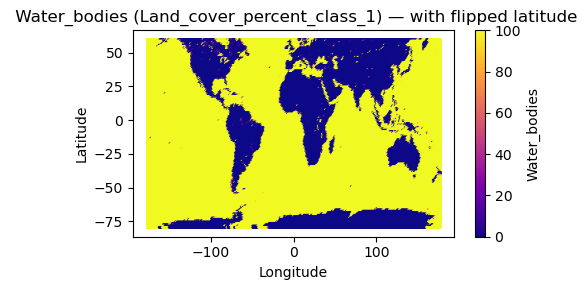

In [31]:
plt.figure(figsize=(5, 3))
plt.scatter(
    land_df_renamed['longitude'],
    -land_df_renamed['latitude'],  # flipped
    c=land_df_renamed['Water_bodies'],
    cmap='plasma',
    s=1
)
plt.colorbar(label='Water_bodies')
plt.title(" Water_bodies (Land_cover_percent_class_1) — with flipped latitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

In [32]:
land_uf = map_points_to_country(land_df_renamed, centroids_df)

Mapped: 177138 / 644280 (27.49%) rows assigned a country
Unique countries assigned: 179


In [33]:
# Before flip
land_uf.loc[land_uf['Deciduous_needleleaf_forests'].idxmax()]

longitude                                  -72.5
latitude                                   -41.5
year                                        2019
Water_bodies                                   8
Evergreen_needleleaf_forests                   0
Evergreen_broadleaf_forests                    0
Deciduous_needleleaf_forests                   6
Deciduous_broadleaf_forests                   72
Mixed_forests                                  0
Closed_shrublands                              0
Open_shrublands                                0
Woody_savannas                                12
Savannas                                       0
Grasslands                                     0
Permanent_wetlands                             0
Croplands                                      0
Urban_and_built_up_lands                       2
Cropland_Natural_vegetation_mosaics            0
Permanent_snow_and_ice                         0
Barren                                         0
country             

In [34]:
land_df_renamed['latitude'] = -land_df_renamed['latitude']

In [35]:
# Aggregate Environmental Data
agg_frames = []
for prefix, fname in VAR_FILES.items():
    df_raw = pd.read_csv(base / fname)
    # (impute NaNs if needed here)
    agg_frames.append(summarise_monthly(df_raw, prefix))

# Merge all aggregated features into a single DataFrame by location and year
env_month = reduce(lambda left, right: left.merge(right, on=['longitude', 'latitude', 'year']), agg_frames)

#  Assign each grid cell to a country
env_ctry = map_points_to_country(env_month, centroids_df)

# Aggregate to country-year (average all variables over all grid cells within each country/year)
env_year = (
    env_ctry
      .drop(columns=['longitude', 'latitude'])
      .groupby(['country', 'year'])
      .mean()
      .reset_index()
)

land_cty = map_points_to_country(land_df_renamed, centroids_df)

# Aggregate land cover to country-year
land_cty_year = (
    land_cty
      .drop(columns=['longitude', 'latitude'])
      .groupby(['country', 'year'])
      .mean()
      .reset_index()
)

# Merge land cover with environmental country-year data
env_year = env_year.merge(land_cty_year, on=['country', 'year'], how='left')

Mapped: 144404 / 194298 (74.32%) rows assigned a country
Unique countries assigned: 161
Mapped: 170196 / 644280 (26.42%) rows assigned a country
Unique countries assigned: 176


<div class="alert alert-info">
  <strong>Features</strong>
</div>

In [36]:
feature_cols = [c for c in env_year.columns if c not in ('country','year')]
len(feature_cols)
feature_cols

['SoilMoi0_10cm_inst_mean',
 'SoilMoi0_10cm_inst_std',
 'SoilMoi0_10cm_inst_min',
 'SoilMoi0_10cm_inst_max',
 'SoilMoi0_10cm_inst_median',
 'SoilMoi0_10cm_inst_skew',
 'SoilMoi10_40cm_inst_mean',
 'SoilMoi10_40cm_inst_std',
 'SoilMoi10_40cm_inst_min',
 'SoilMoi10_40cm_inst_max',
 'SoilMoi10_40cm_inst_median',
 'SoilMoi10_40cm_inst_skew',
 'SoilMoi40_100cm_inst_mean',
 'SoilMoi40_100cm_inst_std',
 'SoilMoi40_100cm_inst_min',
 'SoilMoi40_100cm_inst_max',
 'SoilMoi40_100cm_inst_median',
 'SoilMoi40_100cm_inst_skew',
 'SoilMoi100_200cm_inst_mean',
 'SoilMoi100_200cm_inst_std',
 'SoilMoi100_200cm_inst_min',
 'SoilMoi100_200cm_inst_max',
 'SoilMoi100_200cm_inst_median',
 'SoilMoi100_200cm_inst_skew',
 'SoilTMP0_10cm_inst_mean',
 'SoilTMP0_10cm_inst_std',
 'SoilTMP0_10cm_inst_min',
 'SoilTMP0_10cm_inst_max',
 'SoilTMP0_10cm_inst_median',
 'SoilTMP0_10cm_inst_skew',
 'SoilTMP10_40cm_inst_mean',
 'SoilTMP10_40cm_inst_std',
 'SoilTMP10_40cm_inst_min',
 'SoilTMP10_40cm_inst_max',
 'SoilTMP10_40cm

In [37]:
env_year[feature_cols] = (env_year
                          .sort_values(['country','year'])
                          .groupby('country')[feature_cols]
                          .shift(1))                       # lag by 1

# Drop the first year (2010) – its lag is NaN
env_year = env_year.dropna(subset=feature_cols)

# ---------------------------------------------------------------------------
# COVERAGE CHECK  (2011‑2022 inclusive)
# ---------------------------------------------------------------------------
all_expected = {(c,y) for c in env_year['country'].unique()
                         for y in range(2011, 2023)}
actual       = set(zip(env_year['country'], env_year['year']))
missing      = sorted(all_expected - actual)

if missing:
    print("Missing country‑year rows (after lag):")
    for c,y in missing:
        print(f"   {c:25s}  {y}")
else:
    print("Every country has 2011‑2022 climate rows")

Every country has 2011‑2022 climate rows


In [38]:
# ---------------------------------------------------------------------------
#   MERGE WITH YIELD, ADD LabelYield (t+1) & PrevYield (t)
# ---------------------------------------------------------------------------
yield_df = (pd.read_csv(base / "Yield_and_Production_data.csv")
              .query("Element == 'Yield'")
              .rename(columns={'Country':'country','Year':'year'})
              .drop(columns='Element'))

data = (yield_df
        .merge(env_year, on=['country','year'], how='inner')
        .sort_values(['country','Item','year'])
        .assign(
            LabelYield = lambda d: d.groupby(['country','Item'])['Value'].shift(-1),  # y_{t+1}
            PrevYield  = lambda d: d['Value']                                         # y_{t}
        )
        .dropna(subset=['LabelYield'] + feature_cols)   # remove 2022 rows & gaps
        .reset_index(drop=True))

# ─────────── print row counts (env year is still t) ───────────
print("\nRows ready for modelling")
print("  Train ≤ 2017 :", (data['year'] <= 2017).sum())
print("  Val   18‑19  :", data['year'].between(2018, 2019).sum())
print("  Test  20‑21  :", (data['year'] >= 2020).sum())  # 2020 & 2021 env → 2021 & 2022 yields

# ---------------------------------------------------------------------------
# COLUMN SET‑UP
# ---------------------------------------------------------------------------
feature_cols = [c for c in env_year.columns if c not in ('country','year')]
num_cols     = feature_cols + ['PrevYield']
cat_cols     = ['Item']
label_col    = 'LabelYield'        # <— corrected target

train_df = data.query("year <= 2017")
val_df   = data.query("year >= 2018 and year <= 2019")
test_df  = data.query("year >= 2020")


Rows ready for modelling
  Train ≤ 2017 : 35094
  Val   18‑19  : 9894
  Test  20‑21  : 9938


In [39]:
print(data['year'])

0        2011
1        2012
2        2013
3        2014
4        2015
         ... 
54921    2017
54922    2018
54923    2019
54924    2020
54925    2021
Name: year, Length: 54926, dtype: int64


<div class="alert alert-info">
  <strong>Model</strong>
</div>

In [40]:
# COLUMN SET‑UP
num_cols   = feature_cols + ['PrevYield']   # all numeric features
cat_cols   = ['Item']                       # crop name (one‑hot)
label_col  = 'LabelYield'

train_df = data.query("year <= 2017")
val_df   = data.query("year >= 2018 and year <= 2019")
test_df  = data.query("year >= 2020")

In [ ]:
# SCALER + ONE‑HOT ENCODER
scaler = StandardScaler().fit(train_df[num_cols])
ohe    = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_df[cat_cols])

In [41]:
def build_X(df):
    X_num = scaler.transform(df[num_cols])
    X_cat = ohe.transform(df[cat_cols])
    return np.hstack([X_num, X_cat]).astype('float32')

In [ ]:
X_train, y_train = build_X(train_df), train_df[label_col].values
X_val,   y_val   = build_X(val_df),   val_df[label_col].values
X_test,  y_test  = build_X(test_df),  test_df[label_col].values

In [24]:
#  RMSE function
def rmse(a, b): return np.sqrt(mean_squared_error(a, b))

# === PARAMETER GRID ===
param_grid = {
    'hidden_layer_sizes': [
        (64, 32), (64, 32, 64), (64, 64), (32, 32),
        (128, 32, 64), (128, 128, 64)
    ],
    'alpha': [1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 1e-2],
    'learning_rate_init': [2e-4, 3e-4, 1e-3],
    'activation': ['relu', 'tanh']
}

#  MLP SETUP WITH EARLY STOPPING 
mlp = MLPRegressor(
    solver='adam',
    max_iter=500,
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=len(X_val) / len(X_train),
    random_state=2025
)

#  GRID SEARCH 
grid = GridSearchCV(
    mlp,
    param_grid,
    scoring='neg_root_mean_squared_error', 
    cv=3,
    verbose=3,
    n_jobs=-1,
    return_train_score=True
)
grid.fit(X_train, y_train)

#  BEST MODEL INFO 
print("Best params:", grid.best_params_)
print("Best cross-validated RMSE:", -grid.best_score_)

#  FINAL MODEL EVALUATION 
final_mlp = grid.best_estimator_
print(f"\nRMSE   Train: {rmse(y_train, final_mlp.predict(X_train)):.2f}")
print(f"RMSE   Val  : {rmse(y_val,   final_mlp.predict(X_val)):.2f}")
print(f"RMSE   Test : {rmse(y_test,  final_mlp.predict(X_test)):.2f}")
print(f"MAE    Test : {mean_absolute_error(y_test, final_mlp.predict(X_test)):.2f}")
print(f"Pearson r   : {stats.pearsonr(y_test, final_mlp.predict(X_test))[0]:.3f}")

#  SAVE PREDICTIONS 
test_preds = final_mlp.predict(X_test)
out = test_df[['country', 'Item', 'year']].copy()
out['TrueYield'] = y_test
out['PredYield'] = test_preds
out.to_csv("predictions_mlp.csv", index=False)
print("Saved predictions to predictions_mlp.csv")

#  SAVE MODEL & TRANSFORMERS 
joblib.dump(scaler,     "scaler_mlp.pkl")
joblib.dump(ohe,        "ohe_mlp.pkl")
joblib.dump(final_mlp,  "mlp_model.pkl")
print("Saved model and scalers.")


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (64, 64), 'learning_rate_init': 0.001}
Best cross-validated RMSE: 3694.9068114854686

RMSE   Train: 3474.92
RMSE   Val  : 4067.09
RMSE   Test : 2683.83
MAE    Test : 1030.73
Pearson r   : 0.985
Saved predictions to predictions_mlp.csv
Saved model and scalers.


<div class="alert alert-info">
  <strong>Performance</strong>
</div>

In [49]:
# uncomment to load the model
# scaler = joblib.load("scaler_mlp.pkl")
# ohe    = joblib.load("ohe_mlp.pkl")
# final_mlp = joblib.load("mlp_model.pkl")
# X_test = build_X(test_df)
# y_test = test_df[label_col].values
# y_pred = final_mlp.predict(X_test) 

# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# mae = mean_absolute_error(y_test, y_pred)
# pearson_r = stats.pearsonr(y_test, y_pred)[0]

# print(f"Test RMSE: {rmse:.2f}")
# print(f"Test MAE: {mae:.2f}")
# print(f"Pearson r: {pearson_r:.3f}")
# y_pred = final_mlp.predict(X_test)

Test RMSE: 2683.83
Test MAE: 1030.73
Pearson r: 0.985


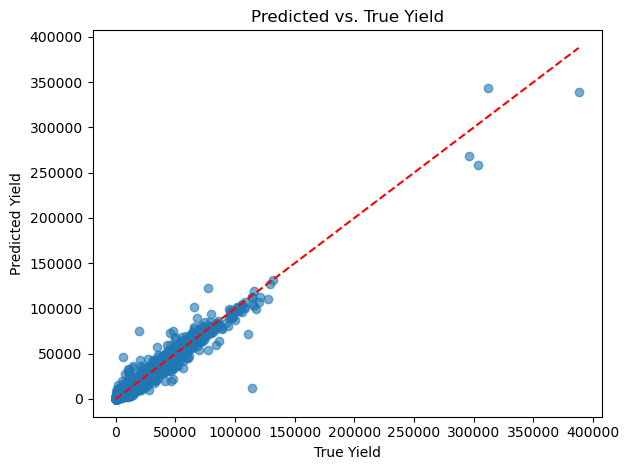

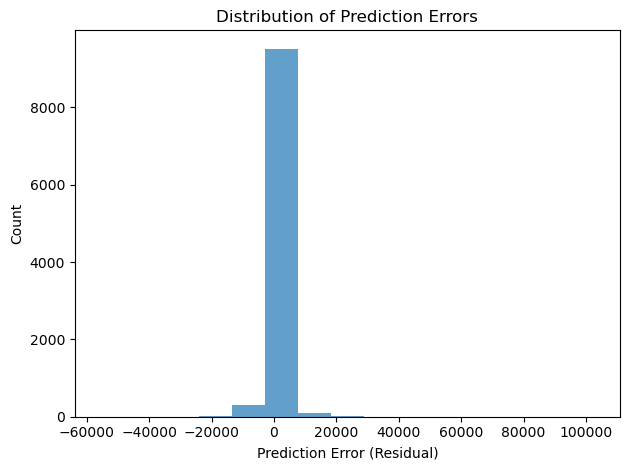

In [52]:


import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("True Yield")
plt.ylabel("Predicted Yield")
plt.title("Predicted vs. True Yield")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()


residuals = y_test - y_pred
plt.hist(residuals, bins=15, alpha=0.7)
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Count")
plt.title("Distribution of Prediction Errors")
plt.tight_layout()
plt.show()

In [55]:
def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))
mean_yield = np.mean(y_test)
print(f"Mean test set yield: {mean_yield:.2f}")
rmse_val = rmse(y_test, final_mlp.predict(X_test))
mae_val = mean_absolute_error(y_test, final_mlp.predict(X_test))
relative_rmse = 100 * rmse_val / mean_yield
relative_mae = 100 * mae_val / mean_yield
print(f"Relative RMSE: {relative_rmse:.2f}%")
print(f"Relative MAE: {relative_mae:.2f}%")

Mean test set yield: 9800.84
Relative RMSE: 27.38%
Relative MAE: 10.52%


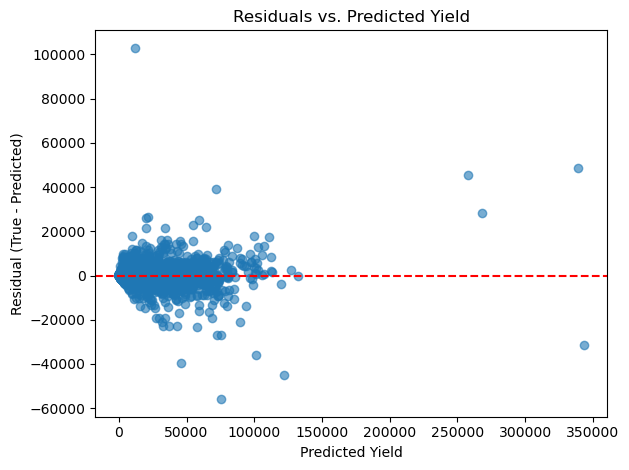

In [56]:
plt.scatter(y_pred, y_test - y_pred, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Yield")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residuals vs. Predicted Yield")
plt.tight_layout()
plt.show()


In [61]:

crop_stats = test_df.groupby('Item').apply(
    lambda df: pd.Series({
        'N': len(df),
        'RMSE': np.sqrt(np.mean(df['Residual'] ** 2)),
        'MAE': np.mean(np.abs(df['Residual']))
    })
).reset_index()

country_stats = test_df.groupby('country').apply(
    lambda df: pd.Series({
        'N': len(df),
        'RMSE': np.sqrt(np.mean(df['Residual'] ** 2)),
        'MAE': np.mean(np.abs(df['Residual']))
    })
).reset_index()

crop_stats_sorted = crop_stats.sort_values('RMSE')
country_stats_sorted = country_stats.sort_values('RMSE')

best_crops = crop_stats_sorted.head(5).reset_index(drop=True)
worst_crops = crop_stats_sorted.tail(5).reset_index(drop=True)
best_countries = country_stats_sorted.head(5).reset_index(drop=True)
worst_countries = country_stats_sorted.tail(5).reset_index(drop=True)

best_crops = best_crops.rename(columns={'Item': 'Crop'})
worst_crops = worst_crops.rename(columns={'Item': 'Crop'})
best_countries = best_countries.rename(columns={'country': 'Country'})
worst_countries = worst_countries.rename(columns={'country': 'Country'})

best_side_by_side = pd.concat([best_crops, best_countries], axis=1, keys=['Best Crops', 'Best Countries'])
worst_side_by_side = pd.concat([worst_crops, worst_countries], axis=1, keys=['Worst Crops', 'Worst Countries'])

print("Best 5 Crops and Best 5 Countries by RMSE:")
display(best_side_by_side.style.format({'RMSE':'{:.2f}', 'MAE':'{:.2f}'}).set_caption("Best Crops and Countries (Lowest RMSE)"))

print("Worst 5 Crops and Worst 5 Countries by RMSE:")
display(worst_side_by_side.style.format({'RMSE':'{:.2f}', 'MAE':'{:.2f}'}).set_caption("Worst Crops and Countries (Highest RMSE)"))

Best 5 Crops and Best 5 Countries by RMSE:


C:\Users\CL\AppData\Local\Temp\ipykernel_158796\1642013546.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  crop_stats = test_df.groupby('Item').apply(
C:\Users\CL\AppData\Local\Temp\ipykernel_158796\1642013546.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_stats = test_df.groupby('country').apply(


Worst 5 Crops and Worst 5 Countries by RMSE:


In [62]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(final_mlp, X_test, y_test, n_repeats=10, random_state=42)

feature_names = num_cols + list(ohe.get_feature_names_out(['Item']))
importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values('Importance', ascending=False).reset_index(drop=True)

# Top 10 and bottom 10 features
top10 = importances.head(10).reset_index(drop=True)
bottom10 = importances.tail(10).reset_index(drop=True)

side_by_side = pd.concat([top10, bottom10], axis=1, keys=['Top 10 Most Important', '10 Least Important'])
display(side_by_side.style.format({'Importance': '{:.3f}', 'Std': '{:.3f}'}).set_caption("Top 10 and 10 Least Important Features (Permutation Importance)"))
